In [406]:
vector_len = 512

In [407]:
!pip install node2vec tensorflow
!pip install gensim 
from deepwalk_config import *
!pwd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content


In [408]:
# optionally load copy
#!7z x copy.zip -o/content

**-------------- Functions --------------**

In [439]:
# choose links from AS file
# samples_number for each link type (peer/customer)

def get_as_data(as_relation_filename, samples_number):
  as_relation_file = open(as_relation_filename, 'r')

  peers = 0
  customers = 0

  X = []
  Y = []

  for line in as_relation_file:
      if line.startswith('#'):
          continue
      data = line.split('|')

      if '0' in data[2]:
          if peers < samples_number:
            X.append([data[0], data[1]])
            Y.append(data[2])
            peers += 1
      else:
          if customers < samples_number:
            X.append([data[0], data[1]])
            Y.append(data[2])
            customers += 1
  return X, Y


def get_as_data2(as_relation_filename, samples_number):
  as_relation_file = open(as_relation_filename, 'r')

  peers = 0

  X = []
  Y = []

  for line in as_relation_file:
      if line.startswith('#'):
          continue
      data = line.split('|')

      if peers < samples_number:
        X.append([data[0], data[1]])
        Y.append(data[2])
        peers += 1
       
  return X, Y

def get_as_data3(as_relation_filename, samples_number, skip):
  as_relation_file = open(as_relation_filename, 'r')

  peers = 0
  skip_ = 0

  X = []
  Y = []

  for line in as_relation_file:
      if line.startswith('#'):
          continue

      if skip_ < skip:
        skip_ += 1
        continue
        
      data = line.split('|')

      if peers < samples_number:
        X.append([data[0], data[1]])
        Y.append(data[2])
        peers += 1
       
  return X, Y



import csv

# create dataset for neural network in format:
# [start_node_embedding], [end_node_embedding], [link_type]
def create_dataset(X, Y, X_embed, dataset_filename):

  out = open(dataset_filename, 'w')
  writer = csv.writer(out)

  for i in range(len(X)):
      data = []
      data.extend(X_embed[X[i][0]])
      data.extend(X_embed[X[i][1]])
      if '0' in Y[i]:
          data.append('0')
      else:
          data.append('1')
      
      writer.writerow(data)

  out.close()


# count links
def display_link_stats(Y):

  peers = 0
  customers = 0

  for y in Y:
      if int(y) == 0:
          peers = peers + 1
      else:
          customers = customers + 1

  print('Peer:', peers, '\n  Customer:', customers)

# embeddings methods ----------------------------------

import networkx as nx
from node2vec import Node2Vec

def node2vec_get_embeddings(as_data):

  embedding_filename = "embeddings_tmp_file"

  # Create a graph 
  graph = nx.Graph()
  for AS in as_data:
      graph.add_edge(AS[0], AS[1])

  # Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
  node2vec = Node2Vec(graph, dimensions=vector_len, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

  # Embed nodes
  model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)
  
  # Save embeddings for later use
  model.wv.save_word2vec_format(embedding_filename)

  embeddings_file = open(embedding_filename,'r')
  node_embeddings = {}

  i = 0
  for line in embeddings_file:
      if i == 0:
          i = i + 1
          continue
      data = line.split(' ')
      node_embeddings[data[0]] = data[1:]

  return node_embeddings


def deepwalk_get_embeddings(as_data, vector_len):

  embedding_filename = "embeddings_tmp_file"
 
 # Create a graph 
  graph = nx.Graph()
  for AS in as_data:
      graph.add_edge(AS[0],AS[1])

  # Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
  model = DeepWalk(graph,walk_length=10,num_walks=80,workers=1)  # Use temp_folder for big graphs
  
  # Embed nodes
  model.train(embed_size=vector_len)# train model

  # Save embeddings for later use
  model.w2v_model.wv.save_word2vec_format(embedding_filename)

  embeddings_file = open(embedding_filename,'r')
  node_embeddings = {}

  i = 0
  for line in embeddings_file:
      if i == 0:
          i = i + 1
          continue
      data = line.split(' ')
      node_embeddings[data[0]] = data[1:]

  return node_embeddings

**-------------- Create datasets --------------**

In [440]:
# create model of neural network

def create_model(vector_len):
  model = Sequential()
  model.add(Dense(32, input_dim=2*vector_len, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

Vector length: 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


Learning embedding vectors...
Learning embedding vectors done!
INFO:tensorflow:Assets written to: model/assets
Result: 99.0
Vector length: 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


Learning embedding vectors...
Learning embedding vectors done!
INFO:tensorflow:Assets written to: model/assets
Result: 100.0
Vector length: 16


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


Learning embedding vectors...
Learning embedding vectors done!
INFO:tensorflow:Assets written to: model/assets
Result: 100.0
Vector length: 32


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


Learning embedding vectors...
Learning embedding vectors done!
INFO:tensorflow:Assets written to: model/assets
Result: 100.0
Vector length: 64


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished


Learning embedding vectors...
Learning embedding vectors done!
INFO:tensorflow:Assets written to: model/assets
Result: 99.0
Vector length: 128


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


Learning embedding vectors...
Learning embedding vectors done!
INFO:tensorflow:Assets written to: model/assets
Result: 100.0
Vector length: 256


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


Learning embedding vectors...
Learning embedding vectors done!
INFO:tensorflow:Assets written to: model/assets
Result: 100.0


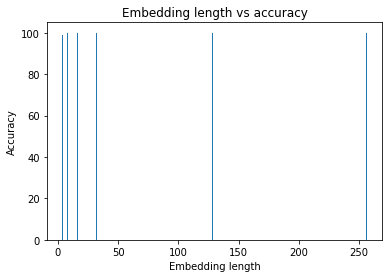

[4, 8, 16, 32, 64, 128, 256]
[99.0, 100.0, 100.0, 100.0, 99.0, 100.0, 100.0]


In [469]:
import csv
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import numpy as np


vector_sizes = []
accuracy = []
for vector_len in [4, 8, 16, 32, 64, 128, 256]:
  print("Vector length:", vector_len)
  #create embeddings and basic dataset
  samples = 1000

  X, Y = get_as_data('as-rank.caida.peercones-with-IX.txt', samples / 2) # balanced
  #display_link_stats(Y)

  X_embed = deepwalk_get_embeddings(X, vector_len)
  create_dataset(X, Y, X_embed, 'dataset_basic.csv')

  # create datasets for training and testing --------------------------------


  def split_data(X, Y):
    
    X_0 = []
    Y_0 = []

    X_1 = []
    Y_1 = []

    for i in range(len(X)):
        if Y[i][0] == '0':
          X_0.append(X[i])
          Y_0.append([0])
        else:
          X_1.append(X[i])
          Y_1.append([1])
          
    return X_0, Y_0, X_1, Y_1

  def write_csv(filename, X, Y):
    out = open(filename, 'w')
    writer = csv.writer(out)
    for i in range(len(X)):
      data = []
      data.extend(X[i])
      data.extend(Y[i])
      writer.writerow(data)


  X = []
  Y = []

  with open('dataset_basic.csv', mode='r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      X.append(row[0:2*vector_len])
      Y.append(row[2*vector_len:])
      

  X_0, Y_0, X_1, Y_1 = split_data(X, Y)

  X.clear()
  Y.clear()

  X.extend(X_0[0:450])
  X.extend(X_1[0:450])

  Y.extend(Y_0[0:450])
  Y.extend(Y_1[0:450])

  write_csv('dataset_balanced.csv', X, Y)

  X.clear()
  Y.clear()
  X.extend(X_0[450:500])
  X.extend(X_1[450:500])

  Y.extend(Y_0[450:500])
  Y.extend(Y_1[450:500])

  write_csv('test_dataset_balanced.csv', X, Y)

  # create, train and save model --------------------------------------


  # load dataset
  dataframe = read_csv("dataset_balanced.csv", header=None)
  #dataframe = shuffle(dataframe)
  dataset = dataframe.values

  # split into input (X) and output (Y) variables
  X = dataset[:,0:2*vector_len].astype(float)
  Y = dataset[:,2*vector_len].astype(int)

  #display_link_stats(Y)
  # evaluate model with standardized dataset
  n_split=2
  use_cross_validation = True

  model=create_model(vector_len)

  if (use_cross_validation == False):
    history = model.fit(X, Y, epochs=8, batch_size=40, verbose=0)
  else:
    for train_index,test_index in KFold(n_splits=n_split, shuffle=True).split(X):

      x_train,x_test=X[train_index],X[test_index]
      y_train,y_test=Y[train_index],Y[test_index]
      validation_data = [x_test, y_test];
      
      history = model.fit(x_train, y_train, epochs=8, batch_size=40, validation_data=validation_data, verbose=0)

  model.save("model")

  # evaluate loaded model ------------------------------------------

  # load dataset
  dataframe = read_csv("test_dataset_balanced.csv", header=None)

  dataset = dataframe.values

  # split into input (X) and output (Y) variables
  X = dataset[:,0:2*vector_len].astype(float)
  Y = dataset[:,2*vector_len]

  #display_link_stats(Y)

  model = keras.models.load_model('model')
  predictions = (model.predict(X) > 0.5).astype(int)

  success = 0
  for i in range(len(X)):
    #print(Y[i], " -> ", predictions[i])
    if int(predictions[i]) == int(Y[i]):
      success += 1
  print("Result:", success/len(X)*100)
  vector_sizes.append(vector_len)
  accuracy.append(success/len(X)*100)


plt.bar(vector_sizes, accuracy)
plt.title('Embedding length vs accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Embedding length')
plt.show()
print(vector_sizes)
print(accuracy)
